## **Import Library**

In [34]:
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter("ignore")

import os, shutil

import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp, resize
from skimage import img_as_ubyte
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import kagglehub
from PIL import ImageFile
import tensorflow.lite as tflite

ImageFile.LOAD_TRUNCATED_IMAGES = True
%load_ext tensorboard
%matplotlib inline



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
print(tf.__version__)

2.19.0


## **Data Loading**

### **Scrapping Dataset from Kaggle**

In [4]:
# Download latest version
path = kagglehub.dataset_download("kartik7813/multi-disease-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1


## **Data Preparation**

In [5]:
# Path dataset lama dan baru
dataset_path = Path("/home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/")
new_dataset_path = Path("dataset")

# Struktur folder yang diinginkan (sesuai gambar)
dataset_structure = {
    "brain_tumor": {
        "test": ["glioma", "meningioma", "normal", "pituitary"],
        "train": ["glioma", "meningioma", "normal", "pituitary"],
        "val": ["glioma", "meningioma", "normal", "pituitary"]
    },
    "pneumonia": {
        "test": ["normal", "pneumonia"],
        "train": ["normal", "pneumonia"],
        "val": ["normal", "pneumonia"]
    },
    "skin_cancer": {
        "test": ["basal_cell_carcinoma", "melanoma", "normal"],
        "train": ["basal_cell_carcinoma", "melanoma", "normal"],
        "val": ["basal_cell_carcinoma", "melanoma", "normal"]
    },
    "tuberculosis": {
        "test": ["normal", "tuberculosis"],
        "train": ["normal", "tuberculosis"],
        "val": ["normal", "tuberculosis"]
    }
}

# Verifikasi isi dataset aktual
print("Verifying dataset structure...")
for disease in dataset_structure.keys():
    disease_path = dataset_path / "datasets" / disease
    if not disease_path.exists():
        print(f"Warning: Disease folder not found - {disease_path}")
        continue
        
    for split in ["train", "test", "val"]:
        split_path = disease_path / split
        if not split_path.exists():
            print(f"Warning: Split folder not found - {split_path}")
            continue
            
        print(f"\nContents of {split_path}:")
        for item in split_path.iterdir():
            print(f" - {item.name}")

Verifying dataset structure...

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/brain_tumor/train:
 - pituitary
 - meningioma
 - normal
 - glioma

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/brain_tumor/test:
 - pituitary
 - meningioma
 - normal
 - glioma

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/brain_tumor/val:
 - menignoma
 - pituitary
 - normal
 - glioma

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/pneumonia/train:
 - normal
 - pneumonia

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/pneumonia/test:
 - normal
 - pneumonia

Contents of /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/

In [6]:
# Buat struktur folder tujuan dengan pengecekan konten
copied_count = 0
existing_count = 0
skipped_count = 0

for disease, splits in tqdm(dataset_structure.items(), desc="Processing diseases"):
    for split, classes in splits.items():
        for cls in classes:
            # Path sumber dan tujuan
            src_path = dataset_path / "datasets" / disease / split / cls
            dest_path = new_dataset_path / disease / split / cls
            
            # Buat folder tujuan jika belum ada
            dest_path.parent.mkdir(parents=True, exist_ok=True)
            
            # Cek apakah folder tujuan sudah ada dan berisi file
            if dest_path.exists():
                existing_files = list(dest_path.glob('*'))
                if existing_files:
                    existing_count += 1
                    print(f"ℹ️ Folder already exists with {len(existing_files)} files: {dest_path}")
                    continue
                else:
                    # Folder ada tapi kosong, lanjutkan copy
                    shutil.rmtree(dest_path)
            
            # Salin folder jika sumber ada
            if src_path.exists():
                try:
                    shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
                    copied_count += 1
                    # Verifikasi hasil copy
                    copied_files = list(dest_path.glob('*'))
                    if not copied_files:
                        print(f"⚠️ Warning: Copied folder is empty: {dest_path}")
                        skipped_count += 1
                        shutil.rmtree(dest_path)
                except Exception as e:
                    print(f"❌ Error copying {src_path}: {str(e)}")
                    skipped_count += 1
            else:
                print(f"⚠️ Warning: Source path not found - {src_path}")
                skipped_count += 1

# Laporan lengkap
print(f"\n📊 Copy Summary:")
print(f"✅ Successfully copied: {copied_count} folders")
print(f"ℹ️ Already existed: {existing_count} folders")
print(f"⏭️ Skipped: {skipped_count} folders")
print(f"\nTotal processed: {copied_count + existing_count + skipped_count} folders")


Processing diseases:   0%|                                                                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

⚠️ Warning: Source path not found - /home/noir/.cache/kagglehub/datasets/kartik7813/multi-disease-image-classification/versions/1/datasets/brain_tumor/val/meningioma


Processing diseases: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:13<00:00, 123.32s/it]


📊 Copy Summary:
✅ Successfully copied: 32 folders
ℹ️ Already existed: 0 folders
⏭️ Skipped: 1 folders

Total processed: 33 folders


In [7]:
# Path configuration
dataset_path = Path("dataset")  # Source dataset path
combined_dataset_path = Path("dataset/used/combined")  # Combined dataset path
combined_dataset_path.mkdir(parents=True, exist_ok=True)  # Create main folder

# Disease to organ mapping
disease_to_organ = {
    "brain_tumor": "brain",
    "pneumonia": "lung",
    "skin_cancer": "skin",
    "tuberculosis": "lung"
}

# Initialize counters
copied_count = 0
existing_count = 0
skipped_count = 0

# Process each disease
for disease in tqdm(disease_to_organ.keys(), desc="Processing diseases"):
    organ = disease_to_organ[disease]
    
    for subset in ["train", "test", "val"]:
        subset_path = dataset_path / disease / subset
        
        if not subset_path.exists():
            print(f"⚠️ Subset not found: {subset_path}")
            skipped_count += 1
            continue
            
        for label_folder in subset_path.iterdir():
            if not label_folder.is_dir():
                continue
                
            # Handle normal class naming
            label_name = f"normal_{organ}" if label_folder.name == "normal" else label_folder.name
            target_label_path = combined_dataset_path / label_name
            
            # Create target directory if needed
            target_label_path.mkdir(parents=True, exist_ok=True)
            
            # Check for existing files
            existing_files = list(target_label_path.glob(f"{disease}_{subset}_*"))
            if existing_files:
                existing_count += len(existing_files)
                print(f"ℹ️ Files already exist in {target_label_path} ({len(existing_files)} files)")
                continue
            
            # Copy new files
            for img_file in label_folder.iterdir():
                if img_file.is_file():
                    try:
                        new_filename = f"{disease}_{subset}_{img_file.name}"
                        dest_path = target_label_path / new_filename
                        
                        if not dest_path.exists():
                            shutil.copy(img_file, dest_path)
                            copied_count += 1
                        else:
                            existing_count += 1
                    except Exception as e:
                        print(f"❌ Error copying {img_file}: {e}")
                        skipped_count += 1

# Summary report
print(f"\n📊 Operation Summary:")
print(f"✅ New files copied: {copied_count}")
print(f"ℹ️ Existing files skipped: {existing_count}")
print(f"⚠️ Files skipped due to errors: {skipped_count}")
print(f"\nTotal files in combined dataset: {copied_count + existing_count}")

Processing diseases: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [12:32<00:00, 188.12s/it]


📊 Operation Summary:
✅ New files copied: 21837
ℹ️ Existing files skipped: 0
⚠️ Files skipped due to errors: 0

Total files in combined dataset: 21837


Found 10 classes in the dataset

📁 Class: basal_cell_carcinoma (2000 images)


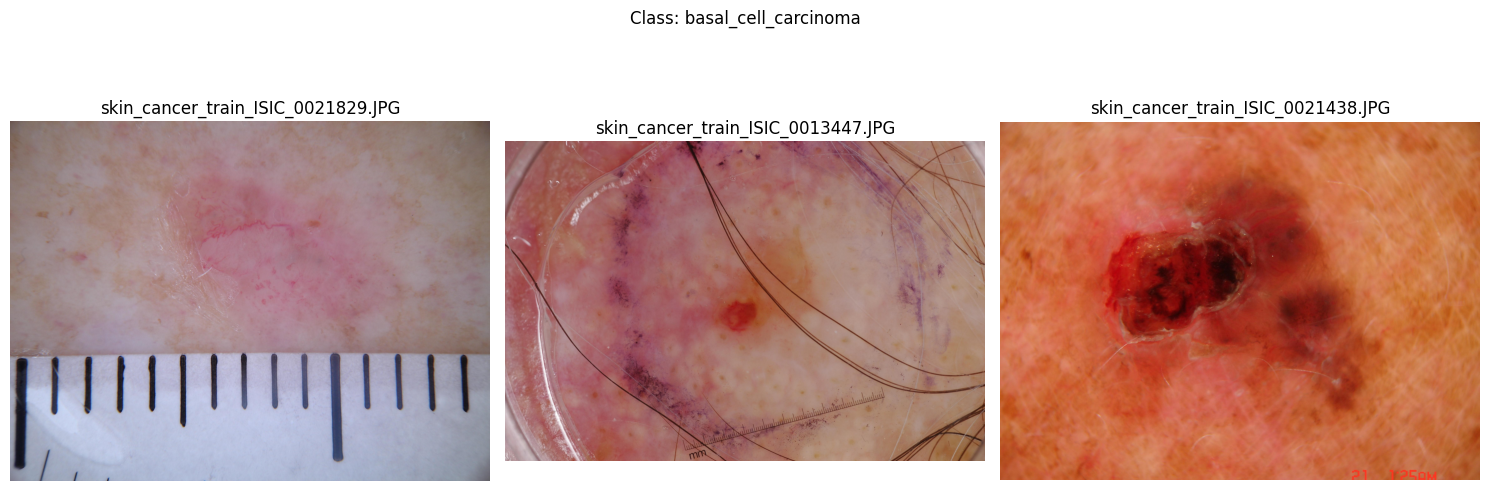


📁 Class: glioma (1921 images)


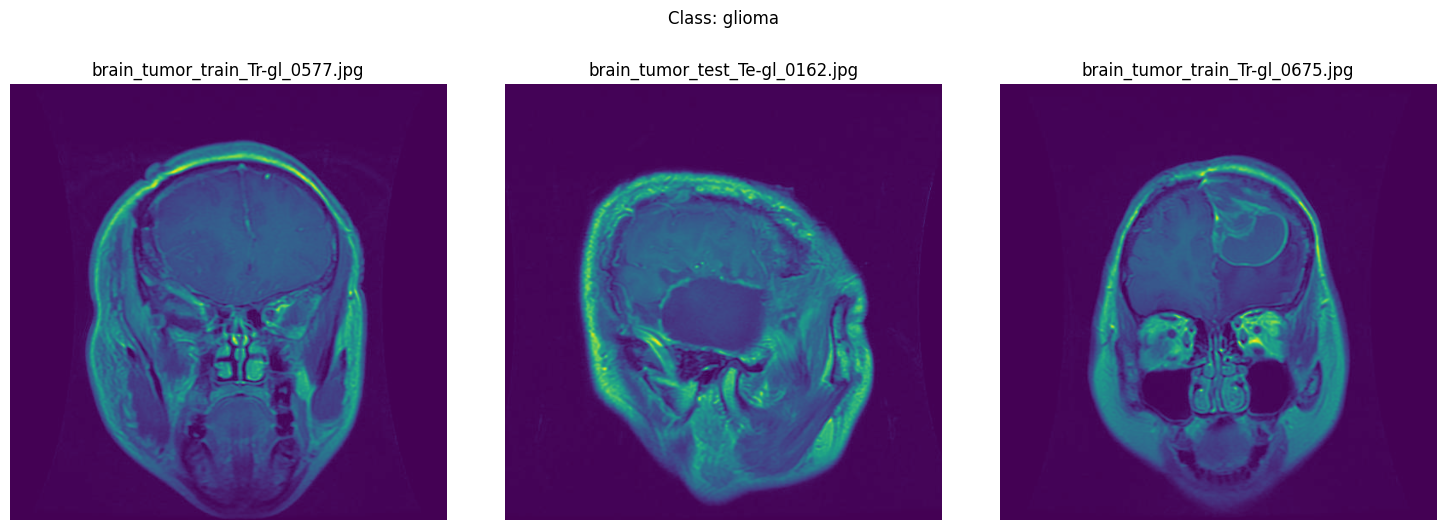


📁 Class: melanoma (2000 images)


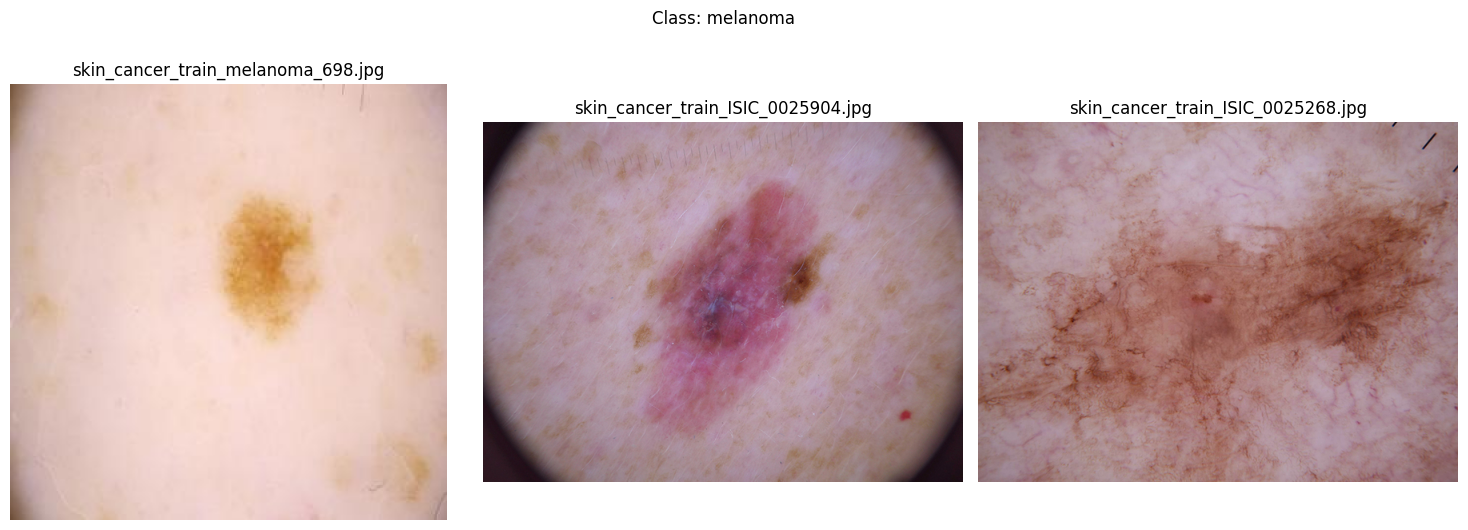


📁 Class: meningioma (1645 images)


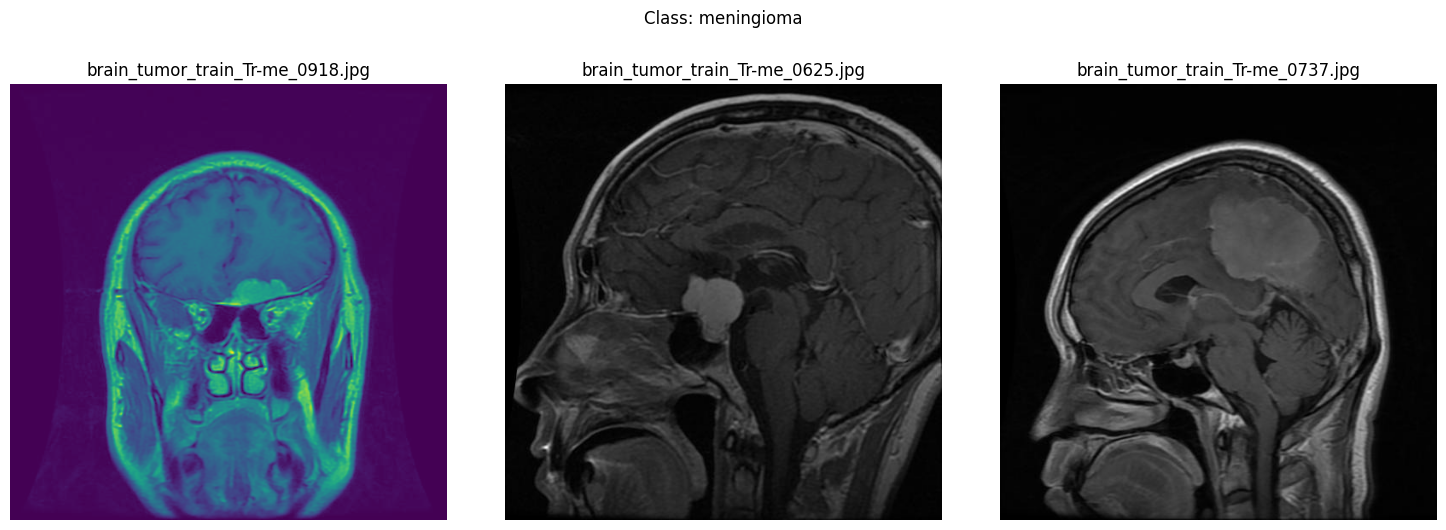


📁 Class: normal_brain (2405 images)


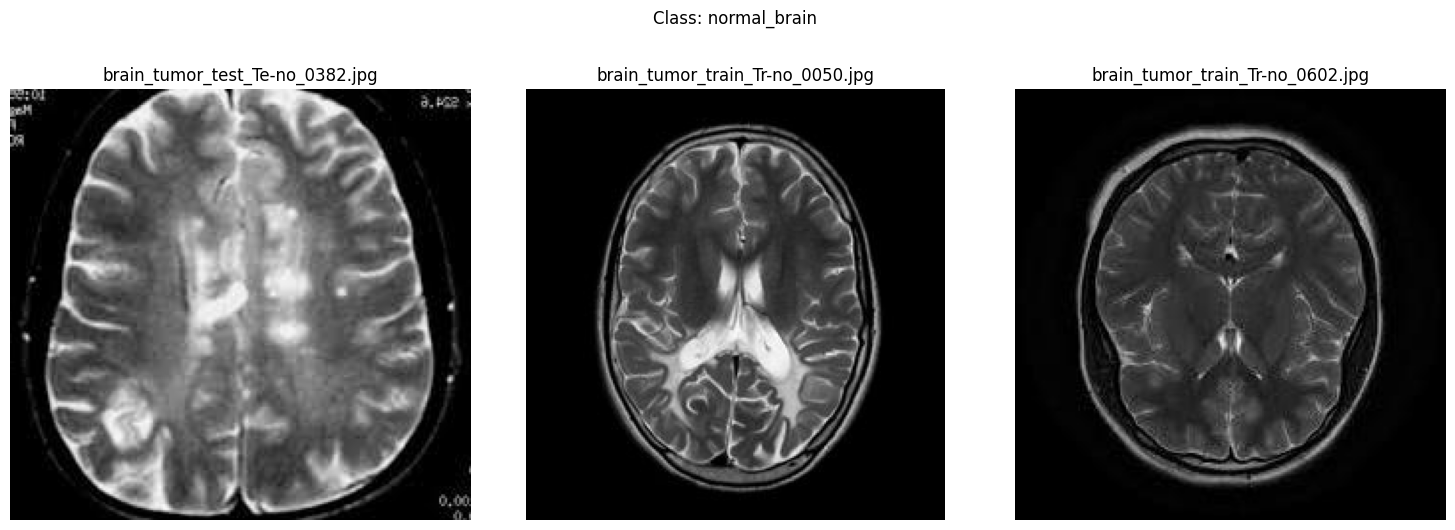


📁 Class: normal_lung (2097 images)


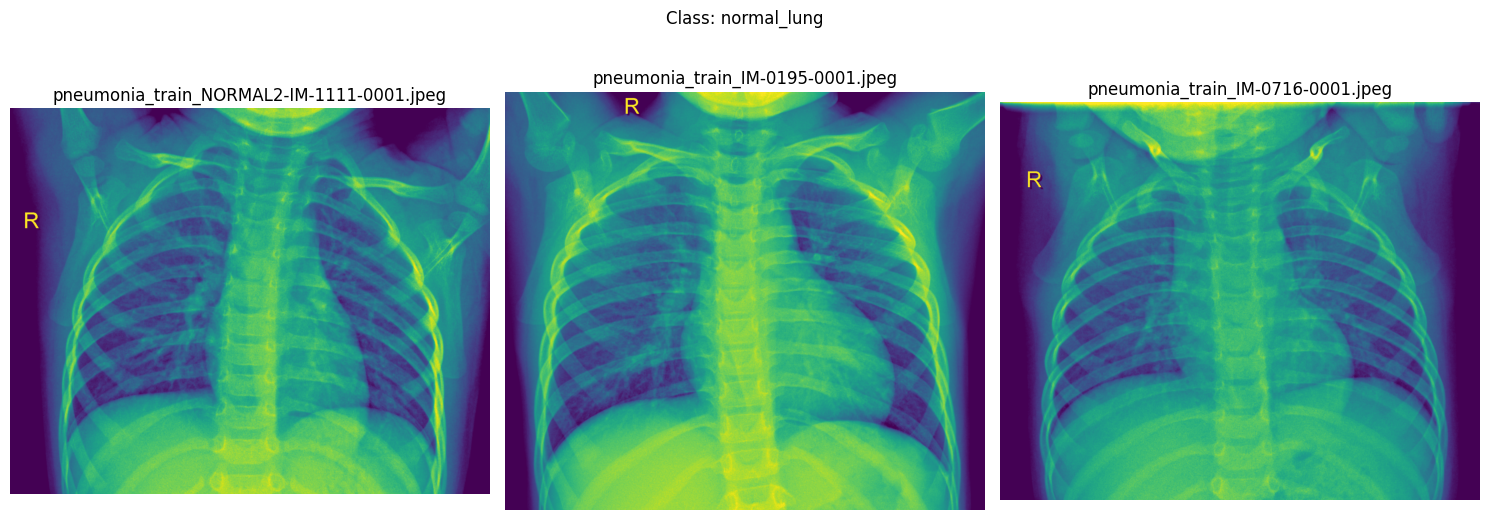


📁 Class: normal_skin (945 images)


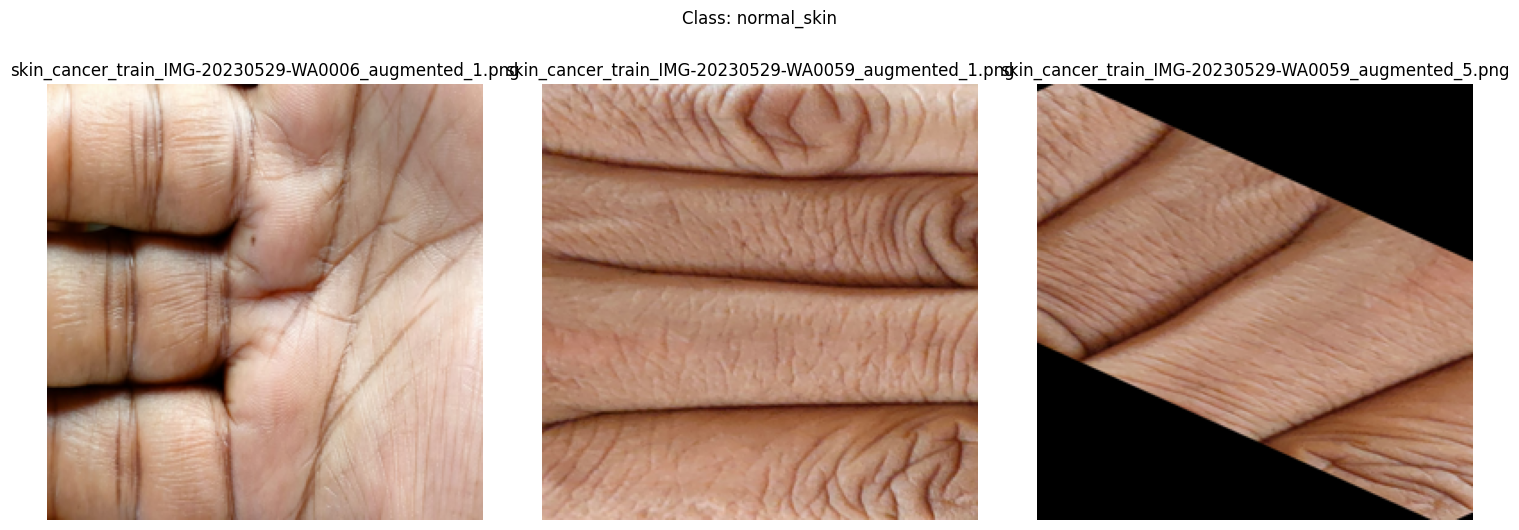


📁 Class: pituitary (2057 images)


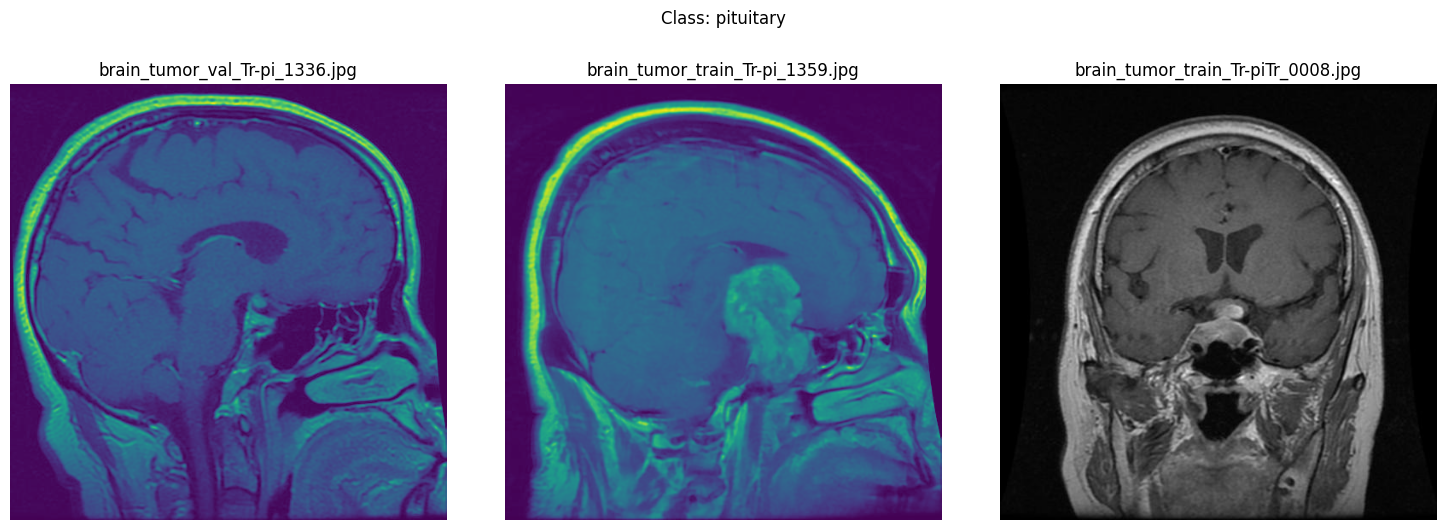


📁 Class: pneumonia (4273 images)


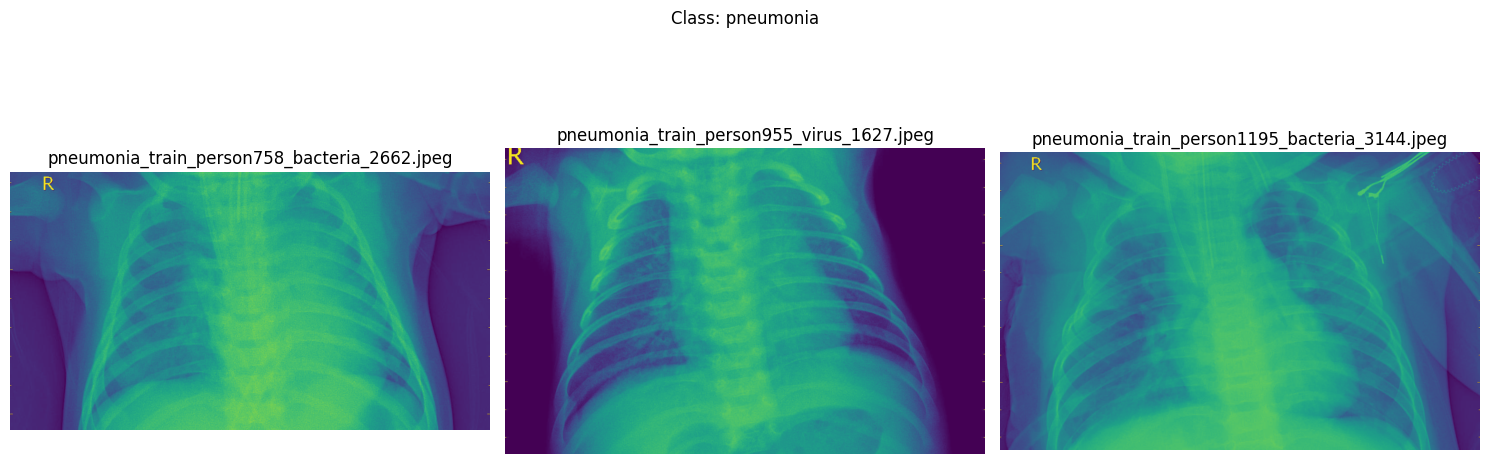


📁 Class: tuberculosis (2494 images)


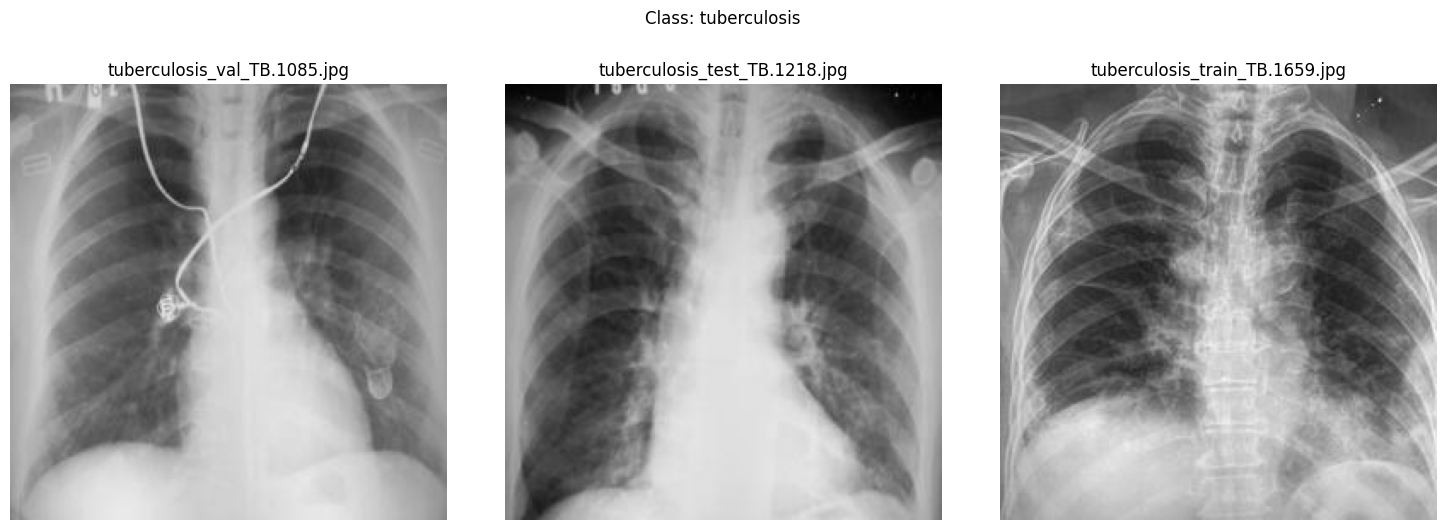

In [8]:
sub_dataset = Path("dataset/used/combined")

# Fungsi yang diperbaiki untuk menampilkan gambar
def show_samples_per_class(root_path, samples_per_class=3):
    
    # Cari semua kelas yang ada (langsung dari folder combined)
    classes = {}
    for class_folder in root_path.iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name
            classes[class_name] = []
            
            # Kumpulkan semua gambar di kelas ini
            for img_file in class_folder.glob('*'):
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    classes[class_name].append(img_file)
    
    print(f"Found {len(classes)} classes in the dataset")
    
    # Tampilkan 3 gambar acak per kelas
    for class_name, img_paths in classes.items():
        print(f"\n📁 Class: {class_name} ({len(img_paths)} images)")
        
        if len(img_paths) == 0:
            print("⚠️ No images found for this class")
            continue
            
        # Ambil sampel acak
        samples = random.sample(img_paths, min(samples_per_class, len(img_paths)))
        
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_name}", y=1.05)
        
        for i, img_path in enumerate(samples, 1):
            plt.subplot(1, samples_per_class, i)
            try:
                img = mpimg.imread(img_path)
                plt.imshow(img)
                plt.title(os.path.basename(img_path))
                plt.axis('off')
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                plt.close()
                break
                
        plt.tight_layout()
        plt.show()

# Tampilkan 3 gambar per kelas
show_samples_per_class(sub_dataset, samples_per_class=3)

In [9]:
print("\n🔍 Directory structure verification:")
if sub_dataset.exists():
    print(f"Contents of {sub_dataset}:")
    for item in sub_dataset.iterdir():
        print(f" - {item.name} ({'folder' if item.is_dir() else 'file'})")
else:
    print(f"Directory {sub_dataset} does not exist")


🔍 Directory structure verification:
Contents of dataset/used/combined:
 - basal_cell_carcinoma (folder)
 - glioma (folder)
 - melanoma (folder)
 - meningioma (folder)
 - normal_brain (folder)
 - normal_lung (folder)
 - normal_skin (folder)
 - pituitary (folder)
 - pneumonia (folder)
 - tuberculosis (folder)


## **Exploratory Data**

In [17]:
# Inisialisasi list untuk menyimpan data
data = []

# Loop melalui semua folder kelas
for class_folder in sub_dataset.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        # Loop melalui semua file dalam folder kelas
        for img_file in class_folder.glob('*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                try:
                    # Buka gambar untuk mendapatkan resolusi
                    with Image.open(img_file) as img:
                        width, height = img.size
                    
                    data.append({
                        'filename': img_file.name,
                        'filepath': str(img_file),
                        'label': class_name,
                        'disease_type': class_name.split('_')[0] if '_' in class_name else 'normal',
                        'width': width,
                        'height': height,
                        'resolution': f"{width}x{height}"
                    })
                except Exception as e:
                    print(f"⚠️ Error processing {img_file}: {str(e)}")
                    continue

# Buat DataFrame
df_original = pd.DataFrame(data)

# Tambahkan kolom tambahan untuk analisis
df_original['image_size'] = df_original['filepath'].apply(lambda x: os.path.getsize(x)) # in bytes
df_original['extension'] = df_original['filename'].apply(lambda x: os.path.splitext(x)[1].lower())

In [18]:
# Tampilkan info dasar
print(f"📊 Total images: {len(df_original)}")
print(f"🏷️ Unique labels: {df_original['label'].nunique()}")
print("\n🔍 Sample data with resolution info:")
display(df_original.head())

# Analisis distribusi kelas dan resolusi
print("\n📈 Class distribution:")
display(df_original['label'].value_counts())

print("\n🖼️ Common resolutions:")
display(df_original['resolution'].value_counts().head(10))

# Analisis statistik resolusi
print("\n📏 Resolution statistics:")
print(f"Average width: {df_original['width'].mean():.0f} px")
print(f"Average height: {df_original['height'].mean():.0f} px")
print(f"\nMinimum resolution: {df_original['width'].min()}x{df_original['height'].min()}")
print(f"Maximum resolution: {df_original['width'].max()}x{df_original['height'].max()}")

📊 Total images: 21837
🏷️ Unique labels: 10

🔍 Sample data with resolution info:


filename  \
0  skin_cancer_test_ISIC_0055895.JPG   
1  skin_cancer_test_ISIC_0055897.JPG   
2  skin_cancer_test_ISIC_0055898.JPG   
3  skin_cancer_test_ISIC_0055912.JPG   
4  skin_cancer_test_ISIC_0055913.JPG   

                                            filepath                 label  \
0  dataset/used/combined/basal_cell_carcinoma/ski...  basal_cell_carcinoma   
1  dataset/used/combined/basal_cell_carcinoma/ski...  basal_cell_carcinoma   
2  dataset/used/combined/basal_cell_carcinoma/ski...  basal_cell_carcinoma   
3  dataset/used/combined/basal_cell_carcinoma/ski...  basal_cell_carcinoma   
4  dataset/used/combined/basal_cell_carcinoma/ski...  basal_cell_carcinoma   

  disease_type  width  height resolution  image_size extension  
0        basal   1024    1024  1024x1024       50083      .jpg  
1        basal   1024    1024  1024x1024       71734      .jpg  
2        basal   1024    1024  1024x1024       36111      .jpg  
3        basal   1024    1024  1024x1024       61058      .jpg  
4        basal   1024    1024  1024x1024       74982      .jpg


📈 Class distribution:


label
pneumonia               4273
tuberculosis            2494
normal_brain            2405
normal_lung             2097
pituitary               2057
basal_cell_carcinoma    2000
melanoma                2000
glioma                  1921
meningioma              1645
normal_skin              945
Name: count, dtype: int64


🖼️ Common resolutions:


resolution
512x512      5337
256x256      2921
600x450      1238
300x300       890
244x244       881
1024x1024     753
225x225       430
3072x2304     398
4288x2848     192
3008x2000     121
Name: count, dtype: int64


📏 Resolution statistics:
Average width: 818 px
Average height: 666 px

Minimum resolution: 150x127
Maximum resolution: 6728x4460


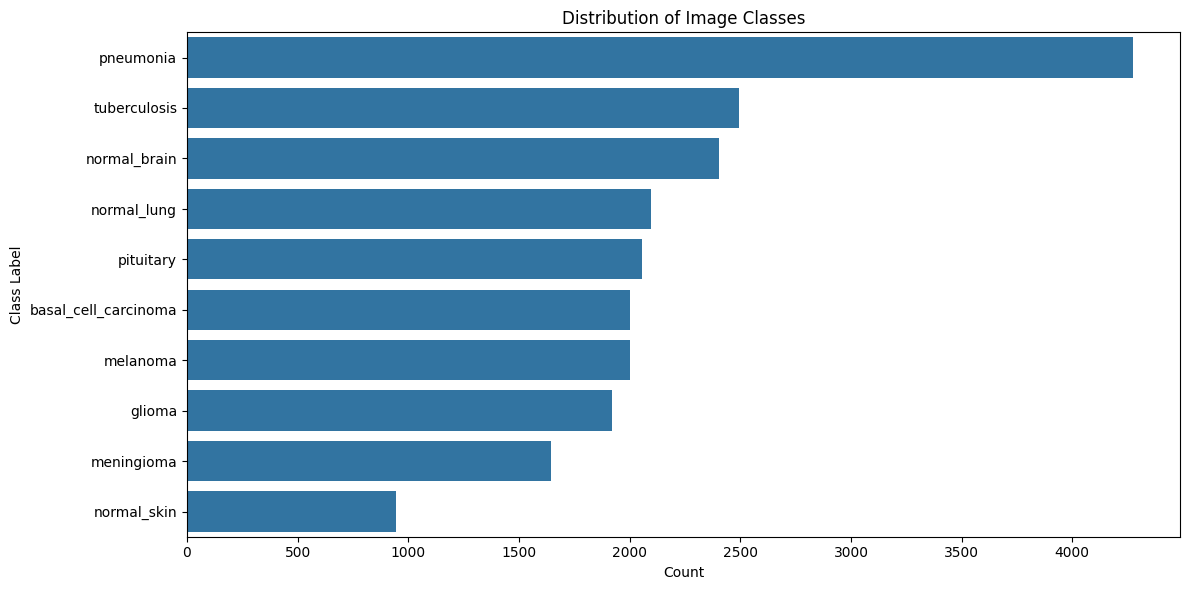

In [12]:
# Visualisasi distribusi kelas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df_original, y='label', order=df_original['label'].value_counts().index)
plt.title('Distribution of Image Classes')
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.tight_layout()
plt.show()

## **Data Augmentation**

In [13]:
# Konfigurasi augmentasi
TARGET_SIZE = (224, 224)

def preprocess_image(img):
    """Fungsi preprocessing standar dengan penanganan format gambar yang lebih baik"""
    # Konversi ke uint8 jika diperlukan
    if img.dtype != np.uint8:
        if img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)
        else:
            img = img_as_ubyte(img)
    
    # Konversi ke 3 channel jika grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # Jika gambar RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = cv2.resize(img, TARGET_SIZE)
    return img

# Optimasi fungsi transformasi
def optimized_rotation(img, angle=None, clockwise=False):
    try:
        img = preprocess_image(img)
        angle = angle if angle is not None else random.randint(5, 180)
        angle = -angle if clockwise else angle
        return rotate(img, angle, mode='edge')
    except Exception as e:
        print(f"Rotation error: {str(e)}")
        return img

def optimized_flip(img, direction='up_down'):
    try:
        img = preprocess_image(img)
        if direction == 'up_down':
            return np.flipud(img)
        elif direction == 'left_right':
            return np.fliplr(img)
        return img
    except Exception as e:
        print(f"Flip error: {str(e)}")
        return img

def optimized_brightness(img, gamma_range=(0.5, 1.5)):
    try:
        img = preprocess_image(img)
        gamma = random.uniform(*gamma_range)
        return adjust_gamma(img, gamma=gamma)
    except Exception as e:
        print(f"Brightness error: {str(e)}")
        return img

def optimized_blur(img, kernel_size=None):
    try:
        img = preprocess_image(img)
        kernel_size = kernel_size or random.choice([(3,3), (5,5), (7,7)])
        return cv2.GaussianBlur(img, kernel_size, 0)
    except Exception as e:
        print(f"Blur error: {str(e)}")
        return img

def optimized_geometric_transform(img, transform_type='shear'):
    try:
        img = preprocess_image(img)
        if transform_type == 'shear':
            transform = AffineTransform(shear=random.uniform(-0.2, 0.2))
        elif transform_type == 'warp':
            transform = AffineTransform(translation=(random.uniform(-20, 20), random.uniform(-20, 20)))
        return warp(img, transform, mode='edge')
    except Exception as e:
        print(f"Transform error: {str(e)}")
        return img

In [14]:
transformations = {
    'rotate_ccw': partial(optimized_rotation, clockwise=False),
    'rotate_cw': partial(optimized_rotation, clockwise=True),
    'flip_ud': partial(optimized_flip, direction='up_down'),
    'flip_lr': partial(optimized_flip, direction='left_right'),
    'brightness': optimized_brightness,
    'blur': optimized_blur,
    'shear': partial(optimized_geometric_transform, transform_type='shear'),
    'warp': partial(optimized_geometric_transform, transform_type='warp')
}

In [15]:
def load_image_safely(img_path):
    """Memuat gambar dengan penanganan format yang aman"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        
        # Konversi ke uint8 jika diperlukan
        if img.dtype != np.uint8:
            img = img_as_ubyte(img)
            
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {str(e)}")
        return None

def augment_class(class_path, save_path, target_count, max_transforms=3):
    """
    Augmentasi gambar dalam satu kelas dengan penanganan error yang lebih baik
    """
    os.makedirs(save_path, exist_ok=True)
    existing_images = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(existing_images)
    
    if current_count == 0:
        print(f"No valid images found in {class_path}")
        return
    
    augment_count = max(0, target_count - current_count)
    augmented = 0
    
    with tqdm(total=augment_count, desc=f"Augmenting {os.path.basename(class_path)}") as pbar:
        while augmented < augment_count:
            img_file = random.choice(existing_images)
            img_path = os.path.join(class_path, img_file)
            
            img = load_image_safely(img_path)
            if img is None:
                continue
                
            try:
                # Terapkan 1-3 transformasi acak
                transforms_to_apply = random.randint(1, max_transforms)
                transformed_img = img.copy()
                
                for _ in range(transforms_to_apply):
                    transform_name = random.choice(list(transformations.keys()))
                    transformed_img = transformations[transform_name](transformed_img)
                    if transformed_img is None:
                        raise ValueError("Transformation returned None")
                
                # Pastikan format output benar
                if transformed_img.dtype != np.uint8:
                    transformed_img = img_as_ubyte(transformed_img)
                
                # Simpan gambar hasil augmentasi
                base_name = os.path.splitext(img_file)[0]
                save_name = f"aug_{base_name}_{augmented}.jpg"
                save_full_path = os.path.join(save_path, save_name)
                
                # Konversi ke BGR untuk penyimpanan OpenCV
                if len(transformed_img.shape) == 3 and transformed_img.shape[2] == 3:
                    transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR)
                
                cv2.imwrite(save_full_path, transformed_img)
                augmented += 1
                pbar.update(1)
                
            except Exception as e:
                print(f"\nError processing image {img_path}: {str(e)}")
                continue

def balance_dataset(dataset_path, augmented_path, balance_method='max'):
    """
    Balance semua kelas dalam dataset
    Args:
        balance_method: 'max' untuk match kelas terbanyak, 
                       atau angka untuk target tetap
    """
    classes = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d))]
    
    if not classes:
        raise ValueError("No classes found in dataset directory")
    
    # Hitung jumlah gambar per kelas
    class_counts = {}
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[cls] = count
    
    # Tentukan target count
    if isinstance(balance_method, int):
        target_count = balance_method
    else:  # 'max'
        target_count = max(class_counts.values())
    
    print("\nDataset Balance Summary:")
    print(f"{'Class':<20} {'Original':<10} {'Augmented Needed':<15}")
    for cls, count in class_counts.items():
        print(f"{cls:<20} {count:<10} {max(0, target_count-count):<15}")
    
    # Proses augmentasi untuk setiap kelas
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        save_path = os.path.join(augmented_path, cls)
        augment_class(cls_path, save_path, target_count)
    
    print("\nAugmentation completed successfully!")

In [16]:
if __name__ == "__main__":
    original_dataset = sub_dataset
    augmented_output = "dataset/used/augmented_balanced"
    
    # Validasi path
    if not os.path.exists(original_dataset):
        raise FileNotFoundError(f"Source dataset not found at {original_dataset}")
    
    # Buat folder output jika belum ada
    os.makedirs(augmented_output, exist_ok=True)
    
    balance_dataset(original_dataset, augmented_output, balance_method='max')


Dataset Balance Summary:
Class                Original   Augmented Needed
basal_cell_carcinoma 2000       2273           
glioma               1921       2352           
melanoma             2000       2273           
meningioma           1645       2628           
normal_brain         2405       1868           
normal_lung          2097       2176           
normal_skin          945        3328           
pituitary            2057       2216           
pneumonia            4273       0              
tuberculosis         2494       1779           


Augmenting pituitary: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2216/2216 [01:15<00:00, 29.35it/s]
Augmenting pneumonia: 0it [00:00, ?it/s]
Augmenting tuberculosis: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1779/1779 [00:44<00:00, 39.63it/s]


Augmentation completed successfully!


## **Merging Dataset**

In [20]:
# Path ke dataset
original_path = Path("dataset/used/combined")
augmented_path = Path("dataset/used/augmented_balanced")
merged_path = Path("dataset/used/merged_dataset")

# Buat folder merged jika belum ada
merged_path.mkdir(parents=True, exist_ok=True)

# Inisialisasi list untuk menyimpan data
data = []

# Fungsi untuk memproses satu folder kelas
def process_class(class_name):
    class_original_path = original_path / class_name
    class_augmented_path = augmented_path / class_name
    class_merged_path = merged_path / class_name
    
    # Buat folder tujuan jika belum ada
    class_merged_path.mkdir(exist_ok=True)
    
    # Salin file dari original
    if class_original_path.exists():
        for img_file in class_original_path.glob('*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                dest_path = class_merged_path / img_file.name
                if not dest_path.exists():
                    shutil.copy(img_file, dest_path)
    
    # Salin file dari augmented
    if class_augmented_path.exists():
        for img_file in class_augmented_path.glob('*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                dest_path = class_merged_path / img_file.name
                if not dest_path.exists():
                    shutil.copy(img_file, dest_path)

# Fungsi untuk membaca metadata gambar
def get_image_metadata(img_path):
    try:
        with Image.open(img_path) as img:
            width, height = img.size
        return {
            'width': width,
            'height': height,
            'resolution': f"{width}x{height}",
            'image_size': os.path.getsize(img_path)
        }
    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {str(e)}")
        return None

# Proses semua kelas
class_names = [d.name for d in original_path.iterdir() if d.is_dir()]
for class_name in tqdm(class_names, desc="Merging datasets"):
    process_class(class_name)

Merging datasets:   0%|                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]

Merging datasets: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [31:53<00:00, 191.38s/it]


In [ ]:

# Bangun DataFrame dari dataset yang sudah digabung
merged_data = []
for class_folder in tqdm(merged_path.iterdir(), desc="Processing merged data"):
    if class_folder.is_dir():
        class_name = class_folder.name
        for img_file in class_folder.glob('*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                metadata = get_image_metadata(img_file)
                if metadata:
                    source = 'original' if 'aug_' not in img_file.name else 'augmented'
                    merged_data.append({
                        'filename': img_file.name,
                        'filepath': str(img_file),
                        'label': class_name,
                        'disease_type': class_name.split('_')[0] if '_' in class_name else 'normal',
                        'source': source,
                        **metadata
                    })

# Buat DataFrame
df_merged = pd.DataFrame(merged_data)
df_merged['extension'] = df_merged['filename'].apply(lambda x: os.path.splitext(x)[1].lower())

# Tampilkan info
print(f"\n📊 Merged Dataset Summary:")
print(f"Total images: {len(df_merged)}")
print(f"Unique labels: {df_merged['label'].nunique()}")
print("\n🔍 Sample data:")
display(df_merged.head())

print("\n📈 Class distribution:")
display(df_merged['label'].value_counts())

print("\n🖼️ Resolution distribution:")
display(df_merged['resolution'].value_counts().head(10))

Processing merged data: 10it [14:45, 88.55s/it]


📊 Merged Dataset Summary:
Total images: 42730
Unique labels: 10

🔍 Sample data:


filename  \
0   aug_skin_cancer_test_ISIC_0055895_191.jpg   
1  aug_skin_cancer_test_ISIC_0055913_1464.jpg   
2   aug_skin_cancer_test_ISIC_0055914_208.jpg   
3    aug_skin_cancer_test_ISIC_0055914_83.jpg   
4   aug_skin_cancer_test_ISIC_0055916_153.jpg   

                                            filepath                 label  \
0  dataset/used/merged_dataset/basal_cell_carcino...  basal_cell_carcinoma   
1  dataset/used/merged_dataset/basal_cell_carcino...  basal_cell_carcinoma   
2  dataset/used/merged_dataset/basal_cell_carcino...  basal_cell_carcinoma   
3  dataset/used/merged_dataset/basal_cell_carcino...  basal_cell_carcinoma   
4  dataset/used/merged_dataset/basal_cell_carcino...  basal_cell_carcinoma   

  disease_type     source  width  height resolution  image_size extension  
0        basal  augmented    224     224    224x224        8913      .jpg  
1        basal  augmented    224     224    224x224       18213      .jpg  
2        basal  augmented    224     224    224x224       10909      .jpg  
3        basal  augmented    224     224    224x224       12753      .jpg  
4        basal  augmented    224     224    224x224        8878      .jpg


📈 Class distribution:


label
basal_cell_carcinoma    4273
glioma                  4273
melanoma                4273
meningioma              4273
normal_brain            4273
normal_lung             4273
normal_skin             4273
pituitary               4273
pneumonia               4273
tuberculosis            4273
Name: count, dtype: int64


🖼️ Resolution distribution:


resolution
224x224      20893
512x512       5337
256x256       2921
600x450       1238
300x300        890
244x244        881
1024x1024      753
225x225        430
3072x2304      398
4288x2848      192
Name: count, dtype: int64

## **Preprocessing & Splitting Dataset**

In [4]:
X = df_merged["filepath"]
y = df_merged["label"]

# Split dataset menjadi data train, validasi, dan test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Jumlah data train   :", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("Jumlah data test    :", len(X_test))

Jumlah data train   : 34184
Jumlah data validasi: 4273
Jumlah data test    : 4273


In [5]:
# Buat DataFrame untuk masing-masing split
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

In [6]:
# Buat generator untuk masing-masing split
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16
)

# Buat generator untuk validasi TANPA augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Tidak perlu shuffle untuk validasi
)

# Buat generator untuk test TANPA augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Tidak perlu shuffle untuk testing
)

Found 34184 validated image filenames belonging to 10 classes.
Found 4273 validated image filenames belonging to 10 classes.
Found 4273 validated image filenames belonging to 10 classes.


## **CNN Model**

### Modelling

In [38]:
tf.keras.backend.clear_session()

# Jumlah kelas
num_classes = df_merged['label'].nunique()

# Membuat model
model = Sequential(
    [
        # Input layer
        InputLayer(input_shape=(224, 224, 3)),
        
        # Block 1 - Reduced filters
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 3 - Simplified
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Feature extraction
        GlobalAveragePooling2D(),
        
        # Classifier - Reduced units
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ]
)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'],
    jit_compile=True
)

# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,882 (827.66 KB)

 Trainable params: 211,242 (825.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [39]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['XLA_FLAGS'] = '--xla_gpu_autotune_level=0'
tf.get_logger().setLevel('ERROR')

In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30, 
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

Epoch 1/30
1099/2137 ━━━━━━━━━━━━━━━━━━━━ 4:58 287ms/step - AUC: 0.9255 - Precision: 0.7092 - Recall: 0.3212 - accuracy: 0.5601 - loss: 1.1515

2025-04-03 11:36:41.433096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 64 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 48 bytes spill stores, 48 bytes spill loads



2137/2137 ━━━━━━━━━━━━━━━━━━━━ 795s 366ms/step - AUC: 0.9436 - Precision: 0.7357 - Recall: 0.4290 - accuracy: 0.6160 - loss: 0.9936 - val_AUC: 0.9853 - val_Precision: 0.8285 - val_Recall: 0.7814 - val_accuracy: 0.8062 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 2/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 680s 318ms/step - AUC: 0.9819 - Precision: 0.8162 - Recall: 0.7362 - accuracy: 0.7796 - loss: 0.5577 - val_AUC: 0.9886 - val_Precision: 0.8551 - val_Recall: 0.7999 - val_accuracy: 0.8327 - val_loss: 0.4385 - learning_rate: 1.0000e-04
Epoch 3/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 734s 343ms/step - AUC: 0.9879 - Precision: 0.8516 - Recall: 0.7954 - accuracy: 0.8251 - loss: 0.4519 - val_AUC: 0.9931 - val_Precision: 0.8854 - val_Recall: 0.8568 - val_accuracy: 0.8739 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 4/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 691s 323ms/step - AUC: 0.9909 - Precision: 0.8704 - Recall: 0.8278 - accuracy: 0.8500 - loss: 0.3857 - val_AUC: 0.9918 - val_Precision: 0.881

### Evaluasi Metrik

In [44]:
train_results = model.evaluate(train_generator)

val_results = model.evaluate(val_generator)

test_results = model.evaluate(test_generator)

2137/2137 ━━━━━━━━━━━━━━━━━━━━ 815s 381ms/step - AUC: 0.9997 - Precision: 0.9887 - Recall: 0.9879 - accuracy: 0.9882 - loss: 0.0434
268/268 ━━━━━━━━━━━━━━━━━━━━ 116s 434ms/step - AUC: 0.9986 - Precision: 0.9669 - Recall: 0.9648 - accuracy: 0.9651 - loss: 0.0957
268/268 ━━━━━━━━━━━━━━━━━━━━ 114s 425ms/step - AUC: 0.9981 - Precision: 0.9707 - Recall: 0.9683 - accuracy: 0.9694 - loss: 0.0987


In [45]:
# Train accuracy
train_loss, train_acc = train_results[0], train_results[1]  # Ambil hanya loss & accuracy
print(f"Train Accuracy: {train_acc:.4f}")
# Val accuracy
val_loss, val_acc = val_results[0], val_results[1]  # Ambil hanya loss & accuracy
print(f"Val Accuracy: {val_acc:.4f}")

# Test accuracy
test_loss, test_acc = test_results[0], test_results[1]  # Ambil hanya loss & accuracy
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9880
Val Accuracy: 0.9644
Test Accuracy: 0.9663


In [46]:
y_pred_prob = model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)
y_true = test_generator.classes

268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step


In [47]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

basal_cell_carcinoma       0.95      0.95      0.95       427
              glioma       0.97      0.95      0.96       427
            melanoma       0.95      0.95      0.95       427
          meningioma       0.92      0.94      0.93       427
        normal_brain       0.98      0.97      0.98       428
         normal_lung       0.97      0.96      0.97       427
         normal_skin       1.00      0.99      0.99       428
           pituitary       0.96      0.97      0.96       428
           pneumonia       0.96      0.98      0.97       427
        tuberculosis       1.00      1.00      1.00       427

            accuracy                           0.97      4273
           macro avg       0.97      0.97      0.97      4273
        weighted avg       0.97      0.97      0.97      4273



In [49]:
print(history.history.keys())

dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss', 'learning_rate'])


### Epoch Visualization

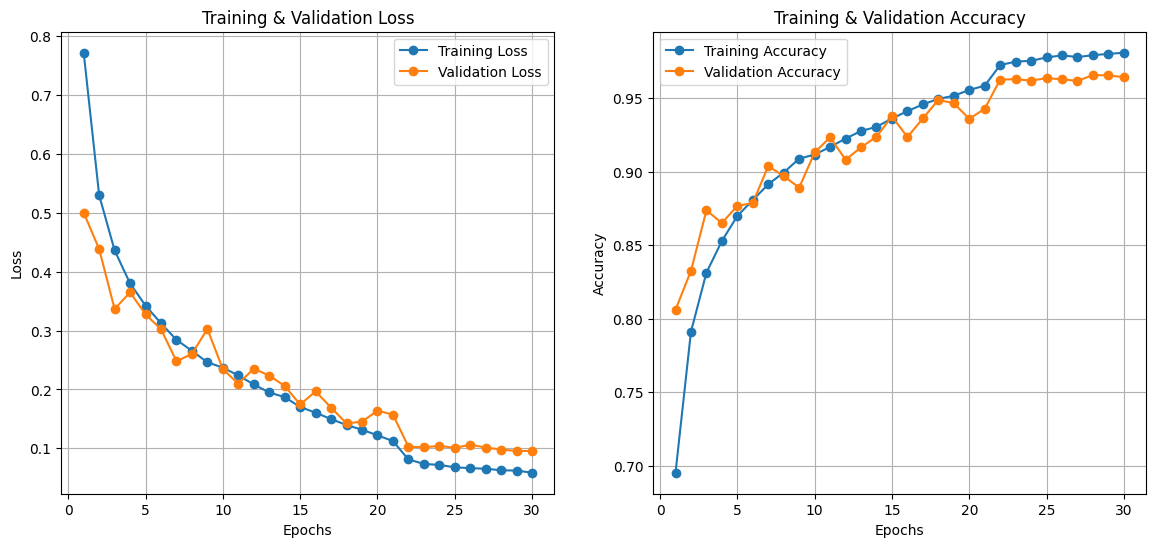

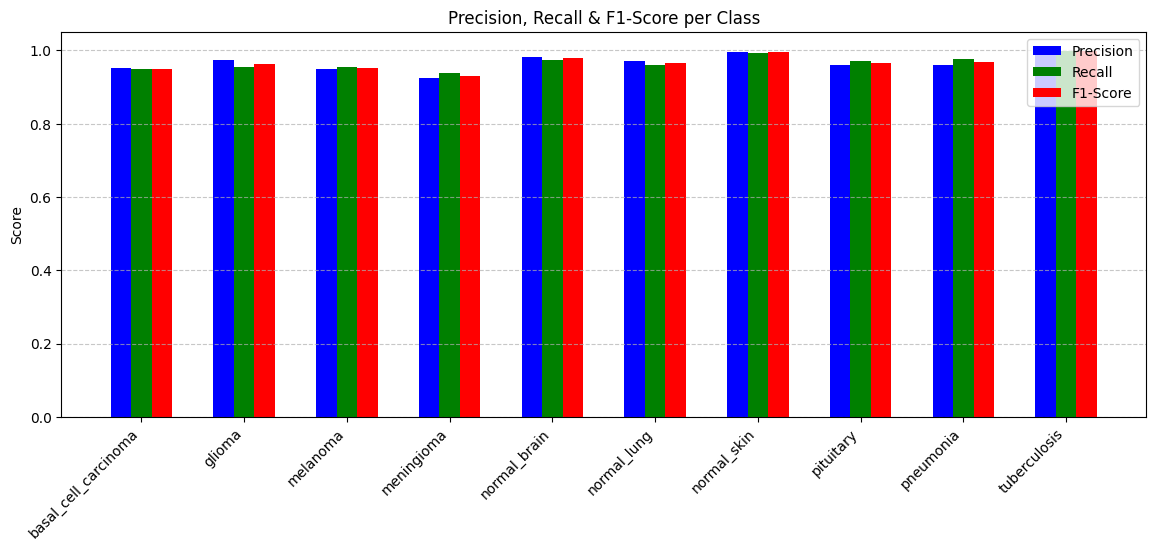

In [53]:
# Fungsi untuk plot Loss & Accuracy
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label="Training Loss", marker='o')
    plt.plot(epochs, history.history['val_loss'], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label="Training Accuracy", marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

# Fungsi untuk plot Precision, Recall, dan F1-Score
def plot_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    x = np.arange(len(class_names))
    
    plt.figure(figsize=(14, 5))
    
    # Precision, Recall, F1-Score
    plt.bar(x - 0.2, precision, width=0.2, label="Precision", color="blue")
    plt.bar(x, recall, width=0.2, label="Recall", color="green")
    plt.bar(x + 0.2, f1, width=0.2, label="F1-Score", color="red")
    
    plt.xticks(ticks=x, labels=class_names, rotation=45, ha='right')
    plt.ylabel("Score")
    plt.title("Precision, Recall & F1-Score per Class")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

# Panggil fungsi dengan data dari training history
plot_training_history(history)

# Panggil fungsi dengan data dari confusion matrix
plot_metrics(y_true, y_pred, list(val_generator.class_indices.keys()))

### Confussion Matrix

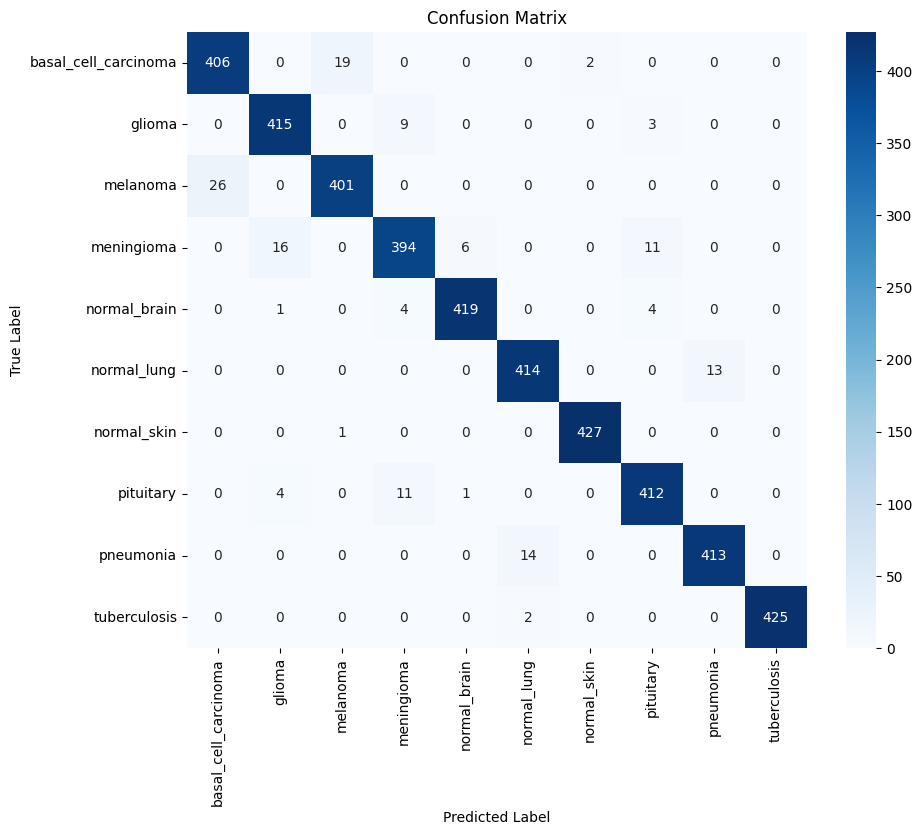

In [ ]:
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## **Export Model**

In [54]:
# save model dalam pb, tfjs dan tflite
model.export("saved_model/multidisease_model")  # Simpan dalam format SavedModel

# Simpan model dalam format TensorFlow.js
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/multidisease_model")
tflite_model = converter.convert()

# Buat folder 'tflite' jika belum ada
os.makedirs("tflite", exist_ok=True)

# Simpan model ke file
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at 'saved_model/multidisease_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140684548585104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564232176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564233408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564231296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564230416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564225488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564226896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684569730336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684569732800: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

W0000 00:00:1743677113.131024    8276 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743677113.131156    8276 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-03 18:45:13.148510: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/multidisease_model
2025-04-03 18:45:13.162494: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-03 18:45:13.162541: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model/multidisease_model
I0000 00:00:1743677113.235601    8276 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-03 18:45:13.260000: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-03 18:45:13.551485: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model/multidisease_model
2025-04-03 18:45:13.622356: I tensorflow

In [56]:
# Simpan model dalam format TensorFlow.js
! tensorflowjs_converter --input_format=tf_saved_model saved_model/multidisease_model tfjs_model

2025-04-03 18:49:13.173817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743677353.207641   47361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743677353.219320   47361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743677353.241331   47361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743677353.241408   47361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743677353.241417   47361 computation_placer.cc:177] computation placer alr

## **Inference with model**

### Inference Saved Model

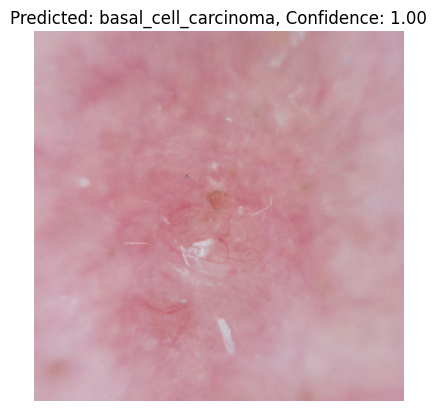

✅ Predicted class: basal_cell_carcinoma, Confidence: 1.00


In [60]:
# Fungsi untuk memuat gambar dan melakukan preprocessing
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
    return img

# Load model dari format SavedModel
model_path = "saved_model/multidisease_model"
exported_model = tf.saved_model.load(model_path)
infer = exported_model.signatures["serving_default"]

def predict_image(image_path, class_indices):
    test_img = preprocess_image(image_path)
    output_pb = infer(keras_tensor=tf.convert_to_tensor(test_img, dtype=tf.float32))
    
    # Ambil prediksi kelas dengan confidence tertinggi
    output_probs = output_pb["output_0"].numpy()[0]
    predicted_class_idx = np.argmax(output_probs)
    predicted_label = list(class_indices.keys())[predicted_class_idx]
    confidence = output_probs[predicted_class_idx]
    
    # Tampilkan hasil prediksi
    plt.imshow(test_img[0])
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()
    
    return predicted_label, confidence

# Contoh penggunaan
image_path = "dataset/skin_cancer/test/basal_cell_carcinoma/ISIC_0055895.jpg"
class_indices = test_generator.class_indices  # Pastikan ini sudah didefinisikan
predicted_label, confidence = predict_image(image_path, class_indices)
print(f"✅ Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

### Inference TF-Lite Model

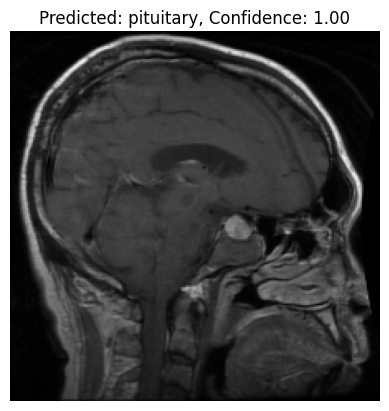

✅ Predicted class: pituitary, Confidence: 1.00


In [59]:
# Fungsi untuk memuat gambar dan melakukan preprocessing
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
    return img

# Load model dari format TF-Lite
tflite_model_path = "tflite/model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Dapatkan indeks input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_image(image_path, class_indices):
    test_img = preprocess_image(image_path)

    # Set input ke model
    interpreter.set_tensor(input_details[0]["index"], test_img.astype(np.float32))

    # Jalankan inferensi
    interpreter.invoke()

    # Ambil hasil output
    output_probs = interpreter.get_tensor(output_details[0]["index"])[0]  # Sudah NumPy array

    # Ambil prediksi kelas dengan confidence tertinggi
    predicted_class_idx = np.argmax(output_probs)
    predicted_label = list(class_indices.keys())[predicted_class_idx]
    confidence = output_probs[predicted_class_idx]

    # Tampilkan hasil prediksi
    plt.imshow(test_img[0])
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    return predicted_label, confidence

# Contoh penggunaan
image_path = "dataset/brain_tumor/test/pituitary/Te-pi_0274.jpg"
class_indices = test_generator.class_indices  # Pastikan ini sudah didefinisikan
predicted_label, confidence = predict_image(image_path, class_indices)
print(f"✅ Predicted class: {predicted_label}, Confidence: {confidence:.2f}")